In [1]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import numpy as np

from coropy.compartmental_models import SEIRModel

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

# 1st wave data
start_date_1 = dt.datetime(2020, 2, 25)
end_date_1 = dt.datetime(2020, 6, 1)
diff = abs((end_date_1 - start_date_1).days)
confirmed_cases_1 = confirmed_cases[:diff+1]
recovered_cases_1 = recovered_cases[:diff+1]
death_cases_1 = death_cases[:diff+1]
daily_tests_1 = daily_tests[:diff+1]

INFO:root:L-BFGS-B optimization started: 2020-10-03 11:01:27.217578
INFO:root:Elapsed time: 31.9337s


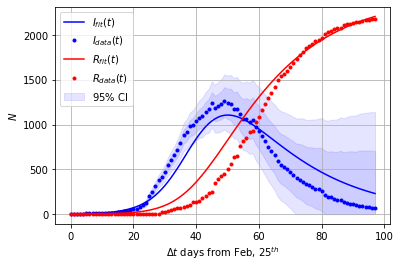

In [3]:
# define initial conditions
S0 = confirmed_cases_1[-1] + 0.1 * confirmed_cases_1[-1]
E0 = 3 * confirmed_cases_1[0]
I0 = confirmed_cases_1[0]
R0 = recovered_cases_1[0] + death_cases_1[0]
IC = (S0, E0, I0, R0)

# instantiate a model
model = SEIRModel(calc_ci=True, pcr_sens=0.9, pcr_spec=0.99, daily_tests=daily_tests_1)

# train a model
params, loss = model.fit(confirmed_cases_1, recovered_cases_1, death_cases_1, IC)

# obtain predictions
(S, E, I, R) = model.simulate()

# visualize
fig, ax = plt.subplots()
ax.plot(I[2], 'b-', label='$I_{fit}(t)$')
ax.fill_between(list(range(len(I[0]))), I[0], I[4], color='b', alpha=0.1, label='$95\%$ CI')
ax.fill_between(list(range(len(I[0]))), I[1], I[3], color='b', alpha=0.1)
ax.plot(confirmed_cases_1 - recovered_cases_1 - death_cases_1, 'b.', label='$I_{data}(t)$')
ax.plot(R, 'r-', label='$R_{fit}(t)$')
ax.plot(recovered_cases_1 + death_cases_1, 'r.', label='$R_{data}(t)$')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()

INFO:root:L-BFGS-B optimization started: 2020-10-03 11:01:59.579139
INFO:root:Elapsed time: 56.3111s


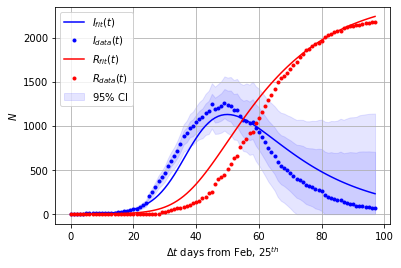

In [4]:
# it is also possible for user to define SEIR-based model 
def SEIR_ode(t, y, delta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -0.5*S*I/N - delta*S*E,  # beta is fixed in this ODE system
        0.5*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I, 
        gamma*I,
    ]

# instantiate a model
model2 = SEIRModel(loss_fun='mse', ode_system=SEIR_ode, calc_ci=True, pcr_sens=0.9, pcr_spec=0.99, daily_tests=daily_tests_1)

# train a model
params2, loss2 = model2.fit(confirmed_cases_1, recovered_cases_1, death_cases_1, IC, guess=[0.1, 0.1, 0.1])

# obtain predictions
(S2, E2, I2, R2) = model2.simulate()

# visualize
fig, ax = plt.subplots()
ax.plot(I2[2], 'b-', label='$I_{fit}(t)$')
ax.fill_between(list(range(len(I2[0]))), I2[0], I2[4], color='b', alpha=0.1, label='$95\%$ CI')
ax.fill_between(list(range(len(I2[0]))), I2[1], I2[3], color='b', alpha=0.1)
ax.plot(confirmed_cases_1 - recovered_cases_1 - death_cases_1, 'b.', label='$I_{data}(t)$')
ax.plot(R2, 'r-', label='$R_{fit}(t)$')
ax.plot(recovered_cases_1 + death_cases_1, 'r.', label='$R_{data}(t)$')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()